In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-06-30T16:03:55.203191+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import os
import pickle as pkl

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from catboost import CatBoostRegressor, Pool

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from catboost import __version__ as cb_version
from sklearn import __version__ as sklearn_version

print(f'cb_version: {cb_version}')
print(f'sklearn_version: {sklearn_version}')

cb_version: 0.24.3
sklearn_version: 0.24.2


In [5]:
%watermark --iversions

matplotlib: 3.3.4
seaborn   : 0.11.1
numpy     : 1.20.3
pandas    : 0.25.3



## Reproducibility block

In [6]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED = 309487

In [7]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

## Load data

In [8]:
x_train  = pd.read_csv(os.path.join(DIR_DATA, 'x_train.csv'), index_col= 0)
x_val    = pd.read_csv(os.path.join(DIR_DATA, 'x_val.csv'), index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'), index_col= 0)

with open(os.path.join(DIR_DATA, 'cat_columns.pkl'), 'rb') as pickle_file:
    cat_cols = pkl.load(pickle_file)
    
with open(os.path.join(DIR_DATA, 'num_columns.pkl'), 'rb') as pickle_file:
    num_cols = pkl.load(pickle_file)

In [9]:
x_train.shape, x_val.shape, df_test.shape, len(cat_cols), len(num_cols)

((5592, 1039), (1399, 1039), (3000, 1036), 5, 1025)

отделяем метки от данных

In [10]:
y_train = x_train[['views', 'depth', 'full_reads_percent']]
y_val   = x_val[['views', 'depth', 'full_reads_percent']]

x_train.drop(['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)
x_val.drop(  ['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((5592, 1036), (1399, 1036), (5592, 3), (1399, 3))

In [11]:
x_train.shape

(5592, 1036)

In [12]:
#cat_cols + num_cols


In [13]:
#views
#train_ds_views = Pool(x_train[cat_cols + num_cols],
train_ds_views = Pool(x_train[cat_cols + ['ctr']],
                      y_train[['views']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )

#val_ds_views   = Pool(x_val[cat_cols + num_cols],
val_ds_views   = Pool(x_val[cat_cols + ['ctr']],
                      y_val[['views']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )


#depth
train_ds_depth = Pool(x_train[cat_cols + num_cols],
                      y_train[['depth']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols
                     )

val_ds_depth   = Pool(x_val[cat_cols + num_cols],
                      y_val[['depth']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols
                     )


#full_reads_percent
train_ds_frp = Pool(x_train[cat_cols + num_cols],
                      y_train[['full_reads_percent']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols
                     )

val_ds_frp   = Pool(x_val[cat_cols + num_cols],
                      y_val[['full_reads_percent']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols
                     )

In [14]:
def plot_feature_importance2(inp_model, inp_pool, imp_number = 30):
    
    data = pd.DataFrame({'feature_importance': inp_model.get_feature_importance(inp_pool), 
              'feature_names': inp_pool.get_feature_names()}).sort_values(by=['feature_importance'], 
                                                       ascending=True)
    
    data.nlargest(imp_number, columns="feature_importance").plot(kind='barh', figsize = (30,16)) ## plot top 40 features

In [15]:
def plot_feature_importance(importance,names,model_type, imp_number = 30):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:imp_number], y=fi_df['feature_names'][:imp_number])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

## views

In [16]:
cb_model_views = CatBoostRegressor(iterations=20,
                                 learning_rate=0.1,
                                 depth=4,
                                 random_seed = CB_RANDOMSEED,
                   #n_estimators=100,
                                  )
# Fit model
cb_model_views.fit(train_ds_views,
        #train_data, train_labels,
                   eval_set=val_ds_views, 
                   #plot = True,
                  )

0:	learn: 95855.1193359	test: 83902.7661284	best: 83902.7661284 (0)	total: 267ms	remaining: 5.07s
1:	learn: 90663.1707762	test: 82864.3498765	best: 82864.3498765 (1)	total: 277ms	remaining: 2.49s
2:	learn: 87747.6761494	test: 81643.4624787	best: 81643.4624787 (2)	total: 289ms	remaining: 1.64s
3:	learn: 86205.2212453	test: 80583.4611957	best: 80583.4611957 (3)	total: 300ms	remaining: 1.2s
4:	learn: 81854.5830947	test: 80262.4359215	best: 80262.4359215 (4)	total: 308ms	remaining: 925ms
5:	learn: 80133.6963146	test: 79423.2632484	best: 79423.2632484 (5)	total: 321ms	remaining: 750ms
6:	learn: 79063.1008783	test: 78586.4713525	best: 78586.4713525 (6)	total: 334ms	remaining: 621ms
7:	learn: 75202.4307743	test: 78062.1721212	best: 78062.1721212 (7)	total: 343ms	remaining: 514ms
8:	learn: 72296.0953417	test: 78038.3482867	best: 78038.3482867 (8)	total: 354ms	remaining: 433ms
9:	learn: 69036.5155372	test: 77647.8405323	best: 77647.8405323 (9)	total: 365ms	remaining: 365ms
10:	learn: 66062.8371

In [17]:
# Get predictions and metrics
preds_train_views = cb_model_views.predict(x_train[cat_cols + num_cols])
preds_val_views   = cb_model_views.predict(val_ds_views)

train_score_views = r2_score(y_train["views"], preds_train_views)
val_score_views   = r2_score(y_val["views"],   preds_val_views)

train_score_views, val_score_views

(0.5709449881026821, 0.19963751545920794)

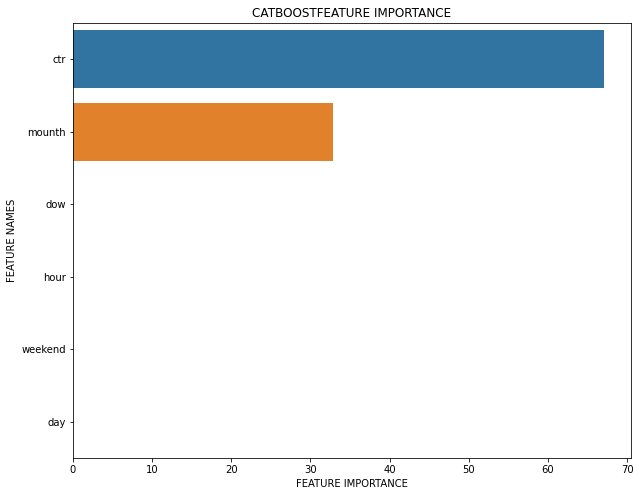

In [18]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_views.get_feature_importance(), train_ds_views.get_feature_names(), 'CATBOOST')

## depth

In [19]:
cb_model_depth = CatBoostRegressor(#iterations=1000,
                                 learning_rate=0.05,
                                 depth=10,
                                 random_seed = CB_RANDOMSEED,
                   n_estimators=100,
                                  )
# Fit model
cb_model_depth.fit(train_ds_depth,
                   eval_set=val_ds_depth, 
                   #plot = True,
                  )

0:	learn: 0.0642519	test: 0.0611611	best: 0.0611611 (0)	total: 3.02s	remaining: 4m 59s
1:	learn: 0.0631383	test: 0.0601384	best: 0.0601384 (1)	total: 6.18s	remaining: 5m 2s
2:	learn: 0.0619203	test: 0.0590642	best: 0.0590642 (2)	total: 9.15s	remaining: 4m 55s
3:	learn: 0.0608471	test: 0.0580257	best: 0.0580257 (3)	total: 12.4s	remaining: 4m 57s
4:	learn: 0.0598320	test: 0.0570242	best: 0.0570242 (4)	total: 15.6s	remaining: 4m 55s
5:	learn: 0.0588117	test: 0.0562370	best: 0.0562370 (5)	total: 18.9s	remaining: 4m 56s
6:	learn: 0.0577544	test: 0.0553993	best: 0.0553993 (6)	total: 22s	remaining: 4m 52s
7:	learn: 0.0568946	test: 0.0546472	best: 0.0546472 (7)	total: 25s	remaining: 4m 47s
8:	learn: 0.0560143	test: 0.0539521	best: 0.0539521 (8)	total: 28.2s	remaining: 4m 45s
9:	learn: 0.0552092	test: 0.0533498	best: 0.0533498 (9)	total: 31.5s	remaining: 4m 43s
10:	learn: 0.0543442	test: 0.0526022	best: 0.0526022 (10)	total: 34.4s	remaining: 4m 38s
11:	learn: 0.0535451	test: 0.0519931	best: 0.0

In [20]:
# Get predictions and metrics
preds_train_depth = cb_model_depth.predict(x_train[cat_cols + num_cols])
preds_val_depth   = cb_model_depth.predict(val_ds_depth)

train_score_depth = r2_score(y_train["depth"], preds_train_depth)
val_score_depth   = r2_score(y_val["depth"],   preds_val_depth)

train_score_depth, val_score_depth

(0.8328090105691034, 0.6882810714363827)

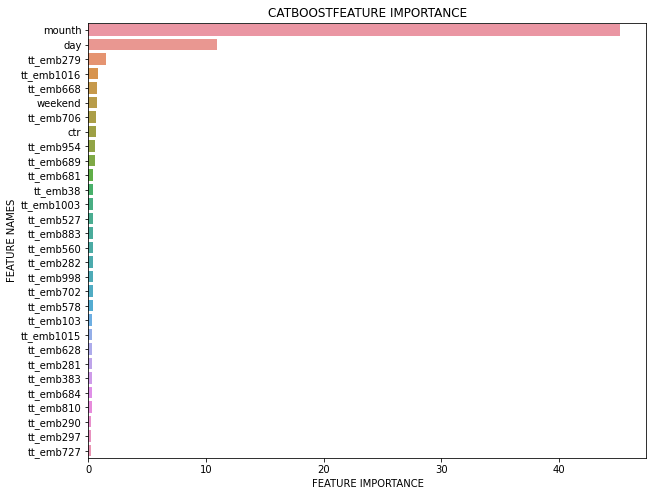

In [21]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_depth.get_feature_importance(), train_ds_depth.get_feature_names(), 'CATBOOST')

## full_reads_percent

In [26]:
cb_model_frp = CatBoostRegressor(#iterations=1000,
                                 learning_rate=0.05,
                                 depth=10,
                                 random_seed = CB_RANDOMSEED,
                   n_estimators=100,
                                 #n_estimators=100,
    #num_trees=None,
                                )
# Fit model
cb_model_frp.fit(train_ds_frp,
                   eval_set=val_ds_frp, 
                   #plot = True,
                  )

0:	learn: 10.5102552	test: 11.2687948	best: 11.2687948 (0)	total: 3.17s	remaining: 5m 14s
1:	learn: 10.3982430	test: 11.1989699	best: 11.1989699 (1)	total: 6.08s	remaining: 4m 57s
2:	learn: 10.2851879	test: 11.1223498	best: 11.1223498 (2)	total: 9.04s	remaining: 4m 52s
3:	learn: 10.1824794	test: 11.0528606	best: 11.0528606 (3)	total: 12.2s	remaining: 4m 53s
4:	learn: 10.0802942	test: 10.9821492	best: 10.9821492 (4)	total: 15.2s	remaining: 4m 49s
5:	learn: 9.9804670	test: 10.9217374	best: 10.9217374 (5)	total: 18.4s	remaining: 4m 47s
6:	learn: 9.8939226	test: 10.8655080	best: 10.8655080 (6)	total: 21.5s	remaining: 4m 45s
7:	learn: 9.8097832	test: 10.8141637	best: 10.8141637 (7)	total: 25s	remaining: 4m 47s
8:	learn: 9.7290678	test: 10.7689155	best: 10.7689155 (8)	total: 28.5s	remaining: 4m 48s
9:	learn: 9.6546101	test: 10.7185260	best: 10.7185260 (9)	total: 31.6s	remaining: 4m 44s
10:	learn: 9.5852226	test: 10.6726496	best: 10.6726496 (10)	total: 34.8s	remaining: 4m 41s
11:	learn: 9.511

In [23]:
# Get predictions and metrics
preds_train_frp = cb_model_frp.predict(x_train[cat_cols + num_cols])
preds_val_frp   = cb_model_frp.predict(val_ds_frp)

train_score_frp = r2_score(y_train["full_reads_percent"], preds_train_frp)
val_score_frp   = r2_score(y_val["full_reads_percent"],   preds_val_frp)

train_score_frp, val_score_frp

(0.5910764058356718, 0.23241501130880693)

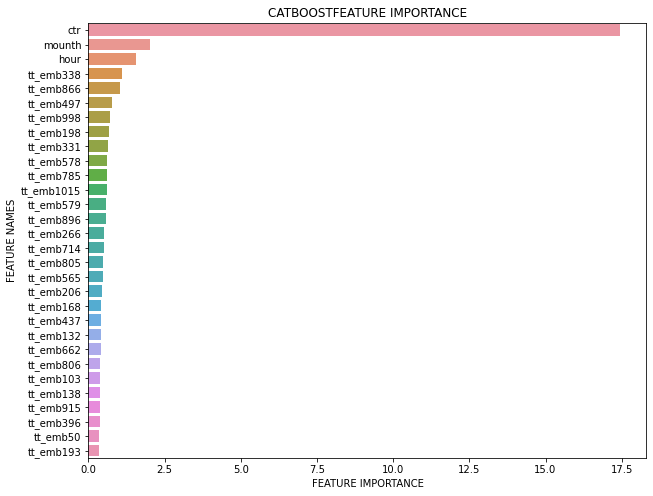

In [24]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_frp.get_feature_importance(), train_ds_frp.get_feature_names(), 'CATBOOST')

In [25]:
score_train = 0.4 * train_score_views + 0.3 * train_score_depth + 0.3 * train_score_frp
score_val  = 0.4 * val_score_views  + 0.3 * val_score_depth  + 0.3 * val_score_frp

score_train, score_val

(0.6555436201625053, 0.3560638310072401)

## save models

In [ ]:
cb_model_views.save_model(os.path.join(DIR_MODELS, 'cb_views.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

cb_model_depth.save_model(os.path.join(DIR_MODELS, 'cb_depth.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

cb_model_frp.save_model(os.path.join(DIR_MODELS, 'cb_frp.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

## make predict

In [ ]:
pred_views = cb_model_views.predict(df_test[cat_cols + num_cols])
pred_depth = cb_model_depth.predict(df_test[cat_cols + num_cols])
pred_frp   = cb_model_frp.predict(  df_test[cat_cols + num_cols])

In [ ]:
subm = pd.DataFrame()
subm['document_id'] = df_test.index

subm['views'] = pred_views
subm['depth'] = pred_depth
subm['full_reads_percent'] = pred_frp

In [ ]:
subm.head()

In [ ]:
subm.to_csv(os.path.join(DIR_SUBM, '3_cb_ttls_emd_depth.csv'), index = False)